Now I will load the exact same dataset (CIFAR-10) from tensorflow and carry out the same pre-processing steps as I did previously.

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


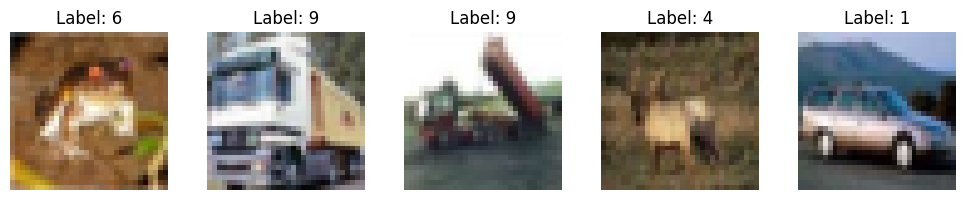

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"Training set shape: {x_train.shape} images")
print(f"Test set shape: {x_test.shape} images")
print(f"Image dimensions: {x_train.shape[1]}x{x_train.shape[2]} pixels")

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i])
    ax.set_title(f"Label: {y_train[i][0]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [2]:
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop, ColorJitter
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]

train_transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

test_transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

x_train_transformed = torch.stack([
    train_transform(Image.fromarray(img)) for img in x_train
])
x_test_transformed = torch.stack([
    test_transform(Image.fromarray(img)) for img in x_test
])

y_train_tensor = torch.tensor(y_train).long()
y_test_tensor = torch.tensor(y_test).long()

In [3]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()

train_dataset = TensorDataset(x_train_transformed, y_train_tensor)
test_dataset = TensorDataset(x_test_transformed, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"
]

def train_model_epoch(model, optimizer, epochs):
    for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            all_labels = []
            all_predictions = []

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            precision = precision_score(all_labels, all_predictions, average='weighted')
            recall = recall_score(all_labels, all_predictions, average='weighted')
            f1 = f1_score(all_labels, all_predictions, average='weighted')

            print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

            if epoch == 9:
                cm = confusion_matrix(all_labels, all_predictions, labels=range(10))

                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
                plt.xlabel("Predicted Labels")
                plt.ylabel("True Labels")
                plt.title("Confusion Matrix")
                plt.show()

Everything is now set up to expand and test with larger neural networks. I will record the training results after each improvement to monitor convergence and metrics and then carry out a final evaluation on the test set.

The last model had 2 convolutional layers, 1 pooling layer and 2 fully connected layers. I will firstly add a dropout layer.

Epoch [1/10], Loss: 1.4531, Accuracy: 49.47%
Precision: 0.4890, Recall: 0.4947, F1 Score: 0.4897
Epoch [2/10], Loss: 0.9836, Accuracy: 65.47%
Precision: 0.6511, Recall: 0.6547, F1 Score: 0.6525
Epoch [3/10], Loss: 0.8071, Accuracy: 71.82%
Precision: 0.7163, Recall: 0.7182, F1 Score: 0.7171
Epoch [4/10], Loss: 0.6631, Accuracy: 76.86%
Precision: 0.7674, Recall: 0.7686, F1 Score: 0.7679
Epoch [5/10], Loss: 0.5388, Accuracy: 81.36%
Precision: 0.8128, Recall: 0.8136, F1 Score: 0.8131
Epoch [6/10], Loss: 0.4223, Accuracy: 85.38%
Precision: 0.8533, Recall: 0.8538, F1 Score: 0.8535
Epoch [7/10], Loss: 0.3380, Accuracy: 88.25%
Precision: 0.8822, Recall: 0.8825, F1 Score: 0.8823
Epoch [8/10], Loss: 0.2790, Accuracy: 90.27%
Precision: 0.9026, Recall: 0.9027, F1 Score: 0.9027
Epoch [9/10], Loss: 0.2424, Accuracy: 91.52%
Precision: 0.9152, Recall: 0.9152, F1 Score: 0.9152
Epoch [10/10], Loss: 0.2334, Accuracy: 92.19%
Precision: 0.9218, Recall: 0.9219, F1 Score: 0.9218


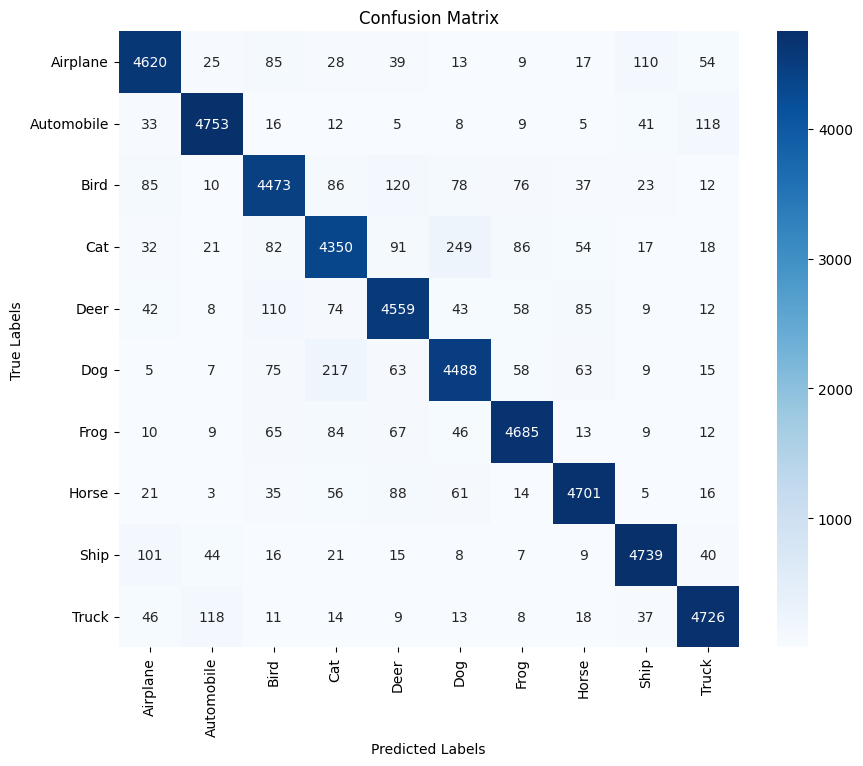

In [5]:
class CNN_Optimized(nn.Module):
    def __init__(self):
        super(CNN_Optimized, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

learning_rate = 0.001
num_epochs = 10

model_optimized = CNN_Optimized()
model_optimized.to(device)

model_optimized_optimizer = torch.optim.RMSprop(
    model_optimized.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_optimized, model_optimized_optimizer, num_epochs)


Now I will add 1 convolutional layer and 1 more pooling layer:

Epoch [1/10], Loss: 1.4805, Accuracy: 47.64%
Precision: 0.4697, Recall: 0.4764, F1 Score: 0.4716
Epoch [2/10], Loss: 0.9986, Accuracy: 64.58%
Precision: 0.6428, Recall: 0.6458, F1 Score: 0.6440
Epoch [3/10], Loss: 0.7799, Accuracy: 72.60%
Precision: 0.7242, Recall: 0.7260, F1 Score: 0.7249
Epoch [4/10], Loss: 0.6435, Accuracy: 77.47%
Precision: 0.7738, Recall: 0.7747, F1 Score: 0.7742
Epoch [5/10], Loss: 0.5221, Accuracy: 81.75%
Precision: 0.8168, Recall: 0.8175, F1 Score: 0.8171
Epoch [6/10], Loss: 0.4261, Accuracy: 85.06%
Precision: 0.8502, Recall: 0.8506, F1 Score: 0.8504
Epoch [7/10], Loss: 0.3458, Accuracy: 87.76%
Precision: 0.8772, Recall: 0.8776, F1 Score: 0.8774
Epoch [8/10], Loss: 0.2866, Accuracy: 89.87%
Precision: 0.8985, Recall: 0.8987, F1 Score: 0.8985
Epoch [9/10], Loss: 0.2512, Accuracy: 91.21%
Precision: 0.9121, Recall: 0.9121, F1 Score: 0.9121
Epoch [10/10], Loss: 0.2152, Accuracy: 92.48%
Precision: 0.9247, Recall: 0.9248, F1 Score: 0.9247


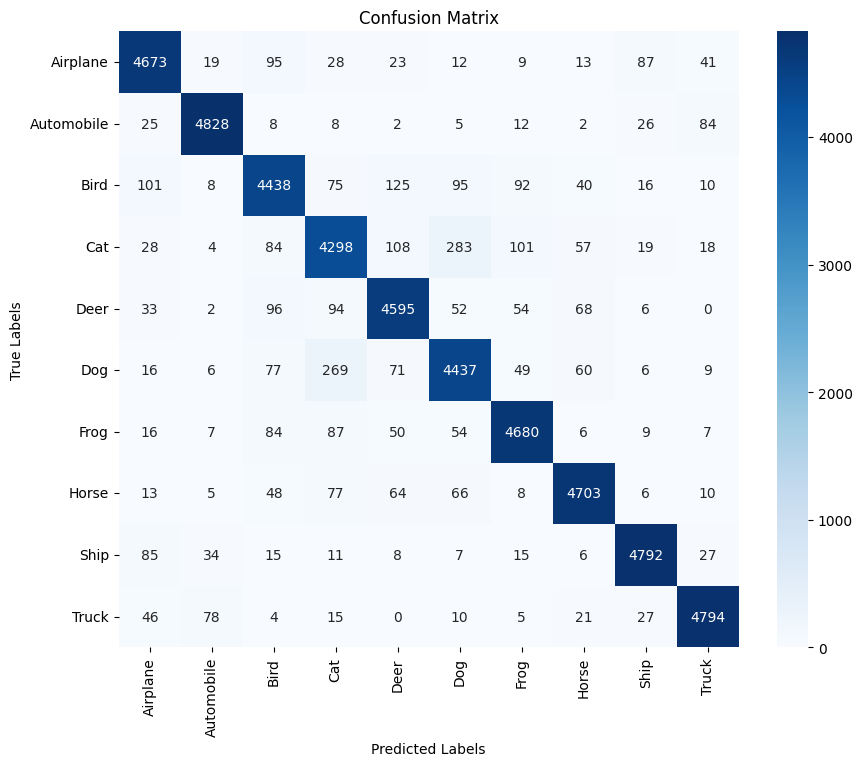

In [6]:
class CNN_Optimized(nn.Module):
    def __init__(self):
        super(CNN_Optimized, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_optimized_2 = CNN_Optimized()
model_optimized_2.to(device)

model_optimized_optimizer_2 = torch.optim.RMSprop(
    model_optimized_2.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_optimized_2, model_optimized_optimizer_2, num_epochs)


Now 1 more convolutional layer and 1 more fully connected layer:

Epoch [1/10], Loss: 1.7693, Accuracy: 40.56%
Precision: 0.4006, Recall: 0.4056, F1 Score: 0.4012
Epoch [2/10], Loss: 1.1445, Accuracy: 59.38%
Precision: 0.5898, Recall: 0.5938, F1 Score: 0.5915
Epoch [3/10], Loss: 0.8810, Accuracy: 69.03%
Precision: 0.6884, Recall: 0.6903, F1 Score: 0.6893
Epoch [4/10], Loss: 0.7268, Accuracy: 74.63%
Precision: 0.7451, Recall: 0.7463, F1 Score: 0.7456
Epoch [5/10], Loss: 0.6084, Accuracy: 78.62%
Precision: 0.7854, Recall: 0.7862, F1 Score: 0.7858
Epoch [6/10], Loss: 0.5102, Accuracy: 82.09%
Precision: 0.8202, Recall: 0.8209, F1 Score: 0.8204
Epoch [7/10], Loss: 0.4370, Accuracy: 84.59%
Precision: 0.8457, Recall: 0.8459, F1 Score: 0.8458
Epoch [8/10], Loss: 0.3656, Accuracy: 87.13%
Precision: 0.8711, Recall: 0.8713, F1 Score: 0.8712
Epoch [9/10], Loss: 0.3134, Accuracy: 88.94%
Precision: 0.8893, Recall: 0.8894, F1 Score: 0.8893
Epoch [10/10], Loss: 0.2718, Accuracy: 90.65%
Precision: 0.9064, Recall: 0.9065, F1 Score: 0.9065


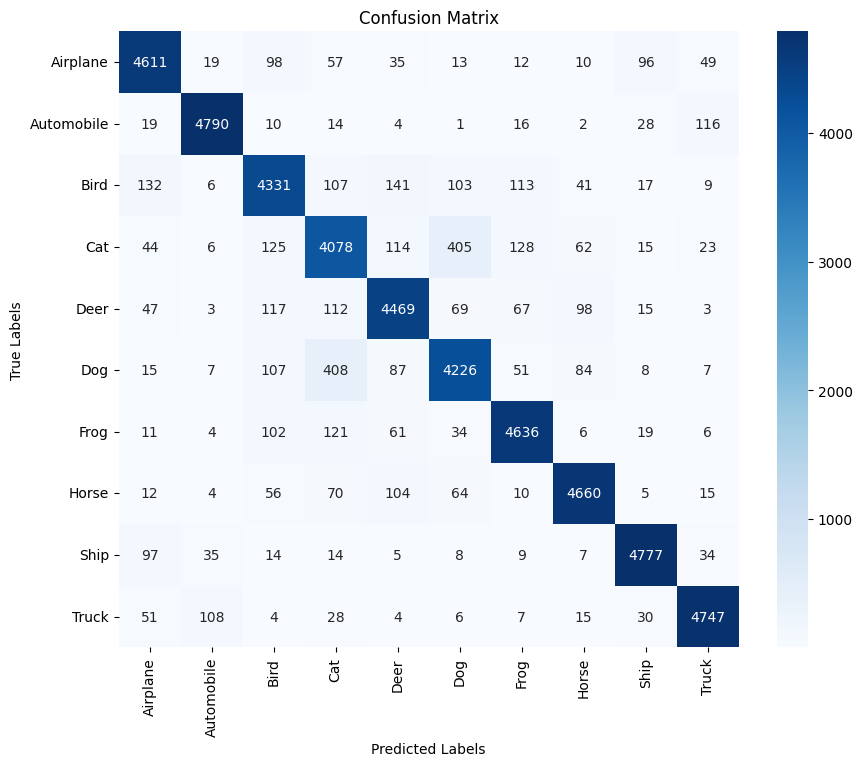

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Optimized(nn.Module):
    def __init__(self):
        super(CNN_Optimized, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_optimized_3 = CNN_Optimized()
model_optimized_3.to(device)

model_optimized_optimizer_3 = torch.optim.RMSprop(
    model_optimized_3.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_optimized_3, model_optimized_optimizer_3, num_epochs)


And 1 more convolutional layer with 1 pooling layer:

Epoch [1/10], Loss: 2.2396, Accuracy: 35.33%
Precision: 0.3472, Recall: 0.3533, F1 Score: 0.3459
Epoch [2/10], Loss: 1.2063, Accuracy: 56.80%
Precision: 0.5633, Recall: 0.5680, F1 Score: 0.5651
Epoch [3/10], Loss: 0.8875, Accuracy: 69.13%
Precision: 0.6890, Recall: 0.6913, F1 Score: 0.6900
Epoch [4/10], Loss: 0.6949, Accuracy: 76.20%
Precision: 0.7609, Recall: 0.7620, F1 Score: 0.7614
Epoch [5/10], Loss: 0.5696, Accuracy: 80.41%
Precision: 0.8032, Recall: 0.8041, F1 Score: 0.8035
Epoch [6/10], Loss: 0.4684, Accuracy: 83.90%
Precision: 0.8387, Recall: 0.8390, F1 Score: 0.8388
Epoch [7/10], Loss: 0.3886, Accuracy: 86.65%
Precision: 0.8663, Recall: 0.8665, F1 Score: 0.8664
Epoch [8/10], Loss: 0.3205, Accuracy: 89.04%
Precision: 0.8902, Recall: 0.8904, F1 Score: 0.8903
Epoch [9/10], Loss: 0.2691, Accuracy: 90.67%
Precision: 0.9066, Recall: 0.9067, F1 Score: 0.9066
Epoch [10/10], Loss: 0.2321, Accuracy: 92.05%
Precision: 0.9204, Recall: 0.9205, F1 Score: 0.9204


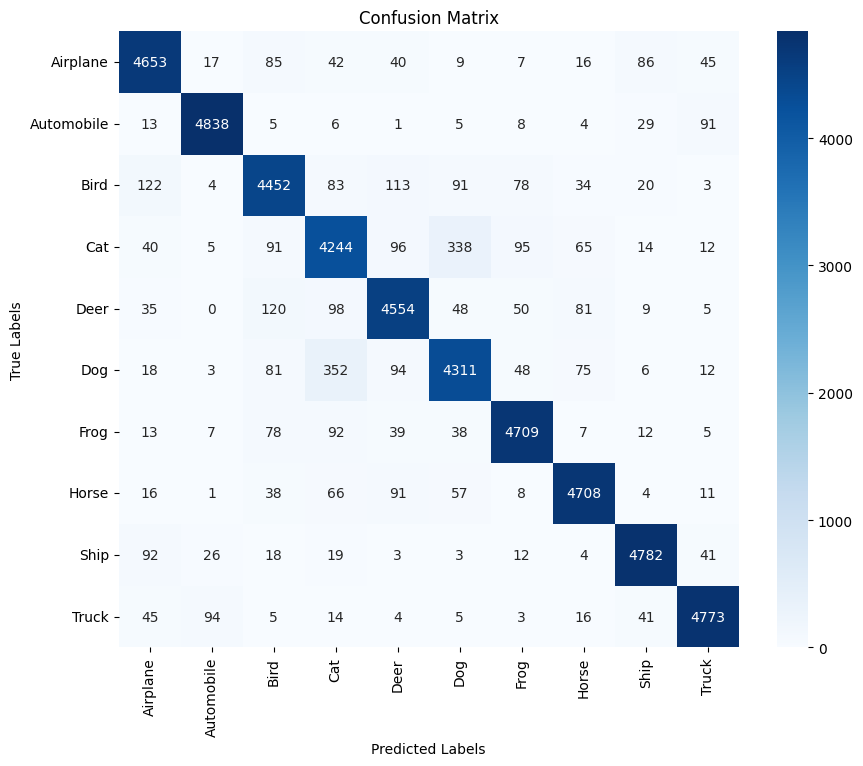

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Optimized(nn.Module):
    def __init__(self):
        super(CNN_Optimized, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_optimized_4 = CNN_Optimized()
model_optimized_4.to(device)

model_optimized_optimizer_4 = torch.optim.RMSprop(
    model_optimized_4.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_optimized_4, model_optimized_optimizer_4, num_epochs)

Now that i've expanded the model and made it more complex, I'll look at some other ways to tweak the model to make it better at generalizing.

I will first test out adding batch normalization to the model after each convolutional layer:

Epoch [1/10], Loss: 2.0577, Accuracy: 32.34%
Precision: 0.3210, Recall: 0.3234, F1 Score: 0.3187
Epoch [2/10], Loss: 1.2212, Accuracy: 55.82%
Precision: 0.5518, Recall: 0.5582, F1 Score: 0.5535
Epoch [3/10], Loss: 0.9323, Accuracy: 67.13%
Precision: 0.6682, Recall: 0.6713, F1 Score: 0.6693
Epoch [4/10], Loss: 0.7713, Accuracy: 73.13%
Precision: 0.7298, Recall: 0.7313, F1 Score: 0.7304
Epoch [5/10], Loss: 0.6583, Accuracy: 77.37%
Precision: 0.7722, Recall: 0.7737, F1 Score: 0.7729
Epoch [6/10], Loss: 0.5744, Accuracy: 80.26%
Precision: 0.8017, Recall: 0.8026, F1 Score: 0.8020
Epoch [7/10], Loss: 0.4985, Accuracy: 83.00%
Precision: 0.8295, Recall: 0.8300, F1 Score: 0.8297
Epoch [8/10], Loss: 0.4397, Accuracy: 84.89%
Precision: 0.8484, Recall: 0.8489, F1 Score: 0.8486
Epoch [9/10], Loss: 0.3823, Accuracy: 87.06%
Precision: 0.8704, Recall: 0.8706, F1 Score: 0.8705
Epoch [10/10], Loss: 0.3320, Accuracy: 88.71%
Precision: 0.8868, Recall: 0.8871, F1 Score: 0.8869


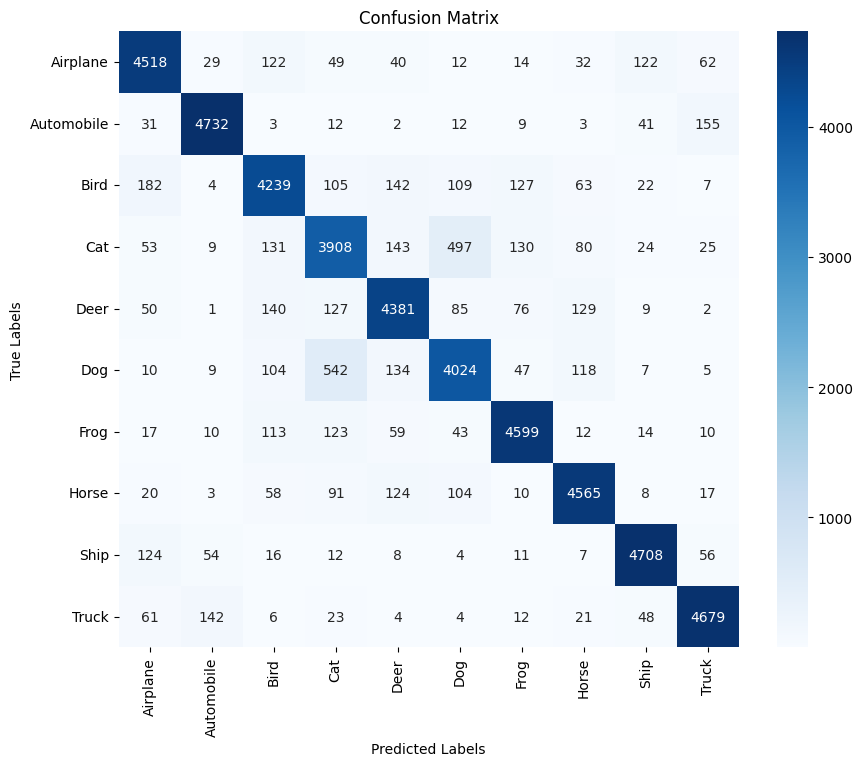

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_BatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_batchnorm = CNN_BatchNorm()
model_batchnorm.to(device)

model_batchnorm_optimizer = torch.optim.RMSprop(
    model_batchnorm.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_batchnorm, model_batchnorm_optimizer, num_epochs)

Adding Batch Normalisation didn't affect the accuracy of the model and doesn't make generalization better. I will try another modification, this time adding global average pooling:

Epoch [1/10], Loss: 1.9903, Accuracy: 35.49%
Precision: 0.3478, Recall: 0.3549, F1 Score: 0.3501
Epoch [2/10], Loss: 1.1324, Accuracy: 59.42%
Precision: 0.5896, Recall: 0.5942, F1 Score: 0.5912
Epoch [3/10], Loss: 0.8809, Accuracy: 69.45%
Precision: 0.6922, Recall: 0.6945, F1 Score: 0.6931
Epoch [4/10], Loss: 0.7336, Accuracy: 74.76%
Precision: 0.7464, Recall: 0.7476, F1 Score: 0.7469
Epoch [5/10], Loss: 0.6292, Accuracy: 78.35%
Precision: 0.7824, Recall: 0.7835, F1 Score: 0.7829
Epoch [6/10], Loss: 0.5445, Accuracy: 81.47%
Precision: 0.8141, Recall: 0.8147, F1 Score: 0.8143
Epoch [7/10], Loss: 0.4770, Accuracy: 83.68%
Precision: 0.8363, Recall: 0.8368, F1 Score: 0.8365
Epoch [8/10], Loss: 0.4159, Accuracy: 85.93%
Precision: 0.8589, Recall: 0.8593, F1 Score: 0.8590
Epoch [9/10], Loss: 0.3612, Accuracy: 87.78%
Precision: 0.8775, Recall: 0.8778, F1 Score: 0.8776
Epoch [10/10], Loss: 0.3146, Accuracy: 89.34%
Precision: 0.8933, Recall: 0.8934, F1 Score: 0.8933


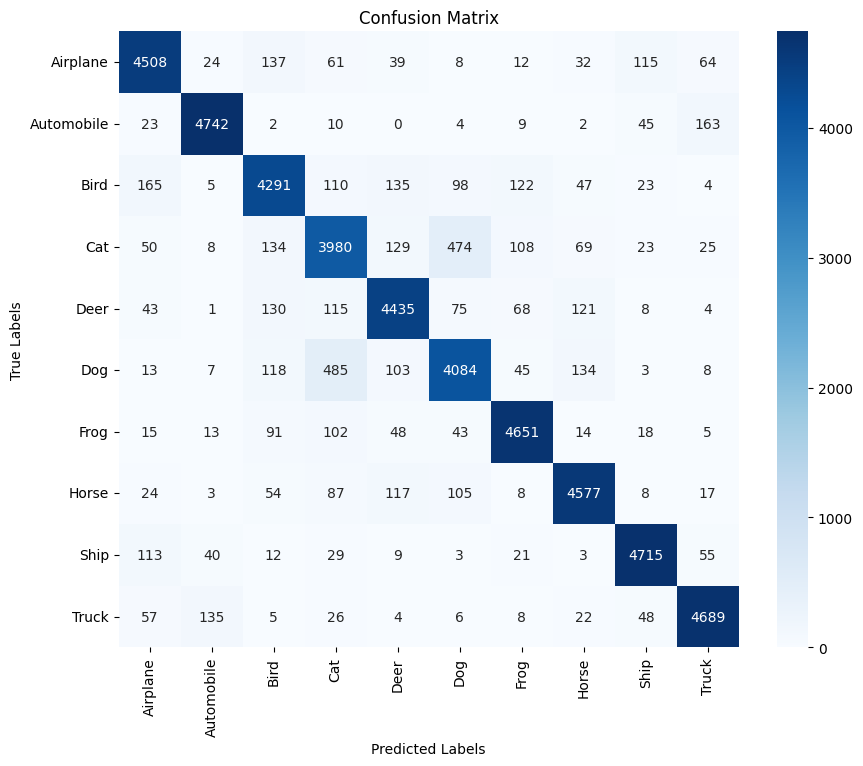

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_GlobalAvgPooling(nn.Module):
    def __init__(self):
        super(CNN_GlobalAvgPooling, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = self.pool3(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_avgpooling = CNN_BatchNorm()
model_avgpooling.to(device)

model_avgpooling_optimizer = torch.optim.RMSprop(
    model_avgpooling.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_avgpooling, model_avgpooling_optimizer, num_epochs)

Global Average Pooling didn't seem to improve accuracy and didn't have any effect on generalization either.

Test Loss: 0.7501, Accuracy: 78.72%
Precision: 0.7945, Recall: 0.7872, F1 Score: 0.7858


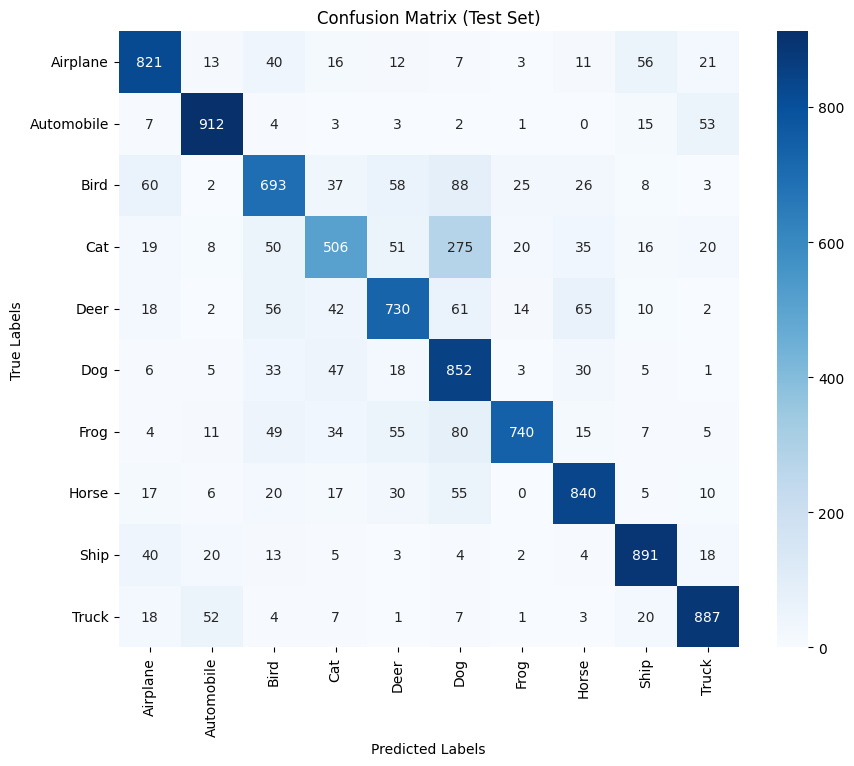

In [24]:
model_optimized_4.eval()
running_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze(1)
        outputs = model_optimized_4(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Test Loss: {running_loss/len(test_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

cm = confusion_matrix(all_labels, all_predictions, labels=range(10))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Test Set)")
plt.show()